### Configuration

In [1]:
args = {
  'country': 'united_states',
  'start_year': 1960,
  'end_year': 2020, # exclusive
  'real_gdp_scale': 1000000,
  'bubble_scale': 0.5,
  'bubble_min_count': 100,
}

### Libraries

In [2]:
import pandas as pd
from flatten_dict import flatten

import constants.tags as TagConstants
import utils.file as File
import utils.visualiser as Visualiser

import utils.firms as Firm

def get_year_count(firms):
  return firms.groupby(['Founded Year']).size()

def get_scaled_year_count(firms, real_gdp):
  year_count = firms.groupby(['Founded Year']).size()
  scaled_year_count = year_count / real_gdp.loc[year_count.index] * args['real_gdp_scale']

  return scaled_year_count

def get_tag_group_year_count(firms, tag_group):
  tag_group_firms = firms[firms['Tag Groups'].apply(lambda firm_tag_group: tag_group in firm_tag_group)]
  tag_group_year_count = tag_group_firms.groupby(['Founded Year']).size()
  tag_group_max_count = tag_group_year_count.max()

  return tag_group_year_count, tag_group_max_count

def get_tag_year_count(firms, tag):
  tag_firms = firms[firms['Tags'].apply(lambda firm_tag: tag in firm_tag)]
  tag_year_count = tag_firms.groupby(['Founded Year']).size()
  tag_max_count = tag_year_count.max()
  
  return tag_year_count, tag_max_count

def get_tag_group_tags(tag_group):
  tag_group_tag_map = TagConstants.tag_group_tag_map
  return tag_group_tag_map[tag_group]

def get_tag_group_tag_count(firms, tag_group):
  tag_group_tags = get_tag_group_tags(tag_group)

  tag_year_count_map = {}
  tag_max_count_map = {}
  for tag in tag_group_tags:
    tag_firms = firms[firms['Tags'].apply(lambda firm_tag: tag in firm_tag)]
    tag_year_count = tag_firms.groupby(['Founded Year']).size()

    tag_year_count_map[tag] = tag_year_count
    tag_max_count_map[tag] = tag_year_count.max()

  return tag_year_count_map, tag_max_count_map

def get_tags():
  tags = [item for sublist in TagConstants.tag_group_tag_map.values() for item in sublist]
  tags = list(set(tags))
  return sorted(tags)


### Run

In [3]:
# Read Firm Data
firms = File.read_pickle(f"{args['country']}_firms")

In [4]:
# Read Domain Data
domain_created_year_map = File.read_pickle('domain_created_year_map')

In [5]:
# Filter Firms
firms = Firm.enrich_founded_year(firms, domain_created_year_map)
firms = Firm.enrich_science(firms, TagConstants.stem_tags)
firms = firms[firms['Company Type'] == 'For Profit']
firms = firms[pd.notna(firms['Founded Year'])]
firms = firms[firms['Founded Year'] >= args['start_year']]
firms = firms[firms['Founded Year'] < args['end_year']]
firms = firms.reset_index(drop=True)

In [6]:
# Read Macro Data
real_gdp = File.read_pickle('real_gdp')
fed_rate = File.read_pickle('fed_rate')

In [7]:
# Filter Macro Data
real_gdp = real_gdp['United States']
real_gdp = real_gdp[real_gdp.index >= args['start_year']]
real_gdp = real_gdp[real_gdp.index < args['end_year']]

fed_rate = fed_rate[fed_rate.index >= args['start_year']]
fed_rate = fed_rate[fed_rate.index < args['end_year']]
# first_fed_rate = fed_rate.loc[fed_rate['Fed Rate'].first_valid_index(), 'Fed Rate']
# fed_rate = fed_rate.reindex(range(args['start_year'], args['end_year'])).fillna(value=first_fed_rate)

In [8]:
year_count = get_year_count(firms)
scaled_year_count = get_scaled_year_count(firms, real_gdp)

stem_year_count, stem_max_count = get_tag_group_year_count(firms, 'Science and Engineering')
# ai_year_count = get_tag_group_year_count(firms, 'Artificial Intelligence (AI)')
# biotech_year_count = get_tag_group_year_count(firms, 'Biotechnology')
search_year_count, search_max_count = get_tag_year_count(firms, 'Search Engine')
solar_year_count, solar_max_count = get_tag_year_count(firms, 'Solar')

stem_tag_group = 'Science and Engineering'
stem_tag_year_count, stem_tag_year_max_count = get_tag_group_tag_count(firms, stem_tag_group)

In [9]:
tags = get_tags()
print(len(tags))
bubble_tags = []

tag_year_count_map = {}
tag_max_count_map = {}
for tag in tags:
  tag_year_count, tag_max_count = get_tag_year_count(firms, tag)
  tag_year_count_map[tag] = tag_year_count
  tag_max_count_map[tag] = tag_max_count

  tag_current_count = tag_max_count
  for year in range(args['end_year'], 0, -1):
    if year in tag_year_count:
        tag_current_count = tag_year_count[year]
        break
  
  if tag_max_count > args['bubble_min_count'] and tag_max_count * args['bubble_scale'] > tag_current_count:
    bubble_tags.append(tag)

print(bubble_tags)
print(len(bubble_tags))

# ai_count = tag_year_count_map['Artificial Intelligence (AI)']
# ai_max = tag_max_count_map['Artificial Intelligence (AI)']
# print(ai_count)
# print(f"ai_max: {ai_max}")
# scaled_max = ai_max * args['bubble_scale']
# print(scaled_max)

#   tag_current_count = ai_max
#   for year in range(args['end_year'], 0, -1):
#     if year in ai_count:
#         tag_current_count = tag_year_count[year]


801
[]
0


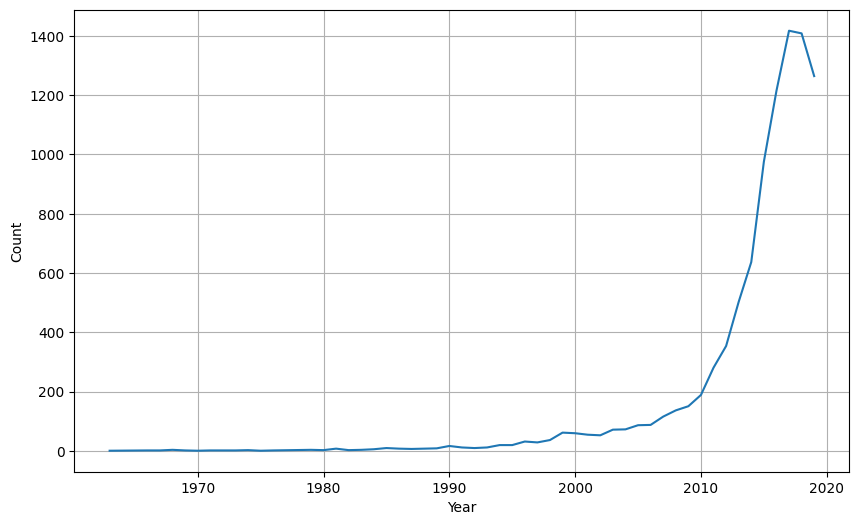

In [10]:
# Visualiser.plot(year_count, 'Count')
# Visualiser.show()

# Visualiser.plot(scaled_year_count, 'Scaled Count')
# Visualiser.show()

# Visualiser.plot(stem_year_count, 'Count')
# Visualiser.show()

Visualiser.plot(tag_year_count_map['Artificial Intelligence (AI)'], 'Count')
Visualiser.show()


# Visualiser.plot(search_year_count, 'Count')
# Visualiser.show()

# Visualiser.plot(solar_year_count, 'Count')
# Visualiser.show()

# Visualiser.plot_dict(stem_tag_year_count, 'Log Count')
# Visualiser.show()